In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from optim_correspondance import (mp_optimize_homography, fix_timing_between_left_and_right,
                                  load_src_and_dest, save_each_frame_to_separate_file)
from multiprocessing import Pool, cpu_count

path_to_files = Path('rawData') / 'calib'
src, dest = load_src_and_dest(path_to_files=path_to_files)

List of keys in dict: ['frames', 'fpa', 'fpa_update_time', 'time_ns']

Number of left frames: 4,389
Number of right frames: 1,194


Length of left: 82
Length of right: 82
Max time difference between frames: 0.00089 seconds
Min time difference between frames: 0.00026 seconds


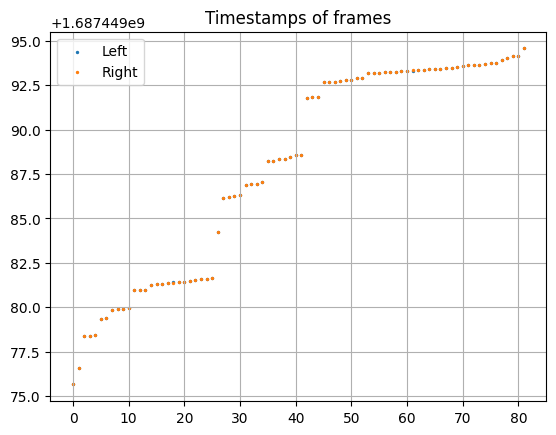

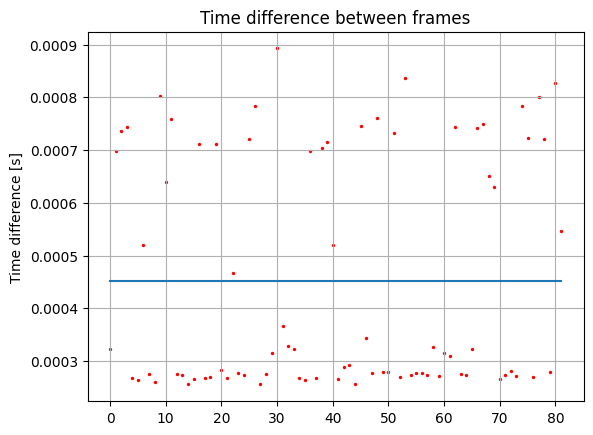

In [2]:
MAX_TIME_DIFF = 0.001  # seconds
src, dest = fix_timing_between_left_and_right(src=src, dest=dest,
                                              max_time_diff=MAX_TIME_DIFF)

In [3]:
save_each_frame_to_separate_file(src=src, dest=dest, path_to_files=path_to_files)

Saved 82 frames to rawData/calib


# Optimize the homography

In [ ]:
DISTANCE_FROM_FRAME_EDGES = 15
LOSS_THRESHOLD_GRAY_LEVELS = 70

list_of_files = list(path_to_files.glob('src_*.npy'))
list_of_files.sort(key=lambda x: int(x.stem.split('src_')[1]))

# Remove all points files
for path in tqdm(path_to_files.glob('points_*.csv'), desc='Remove all points files'):
    path.unlink()
for path in tqdm(path_to_files.glob('M_*.npy'), desc='Remove all homography files'):
    path.unlink()

optimizer = partial(mp_optimize_homography, distance_from_frame_edges=DISTANCE_FROM_FRAME_EDGES,
                    loss_threshold=LOSS_THRESHOLD_GRAY_LEVELS, path_to_files=path_to_files,
                    verbose=True)

# List of files -> list of indices
list_of_indices = list(map(lambda x: int(x.stem.split('src_')[1]), list_of_files))

# Optimize points
with Pool(cpu_count()) as pool:
    ret_vals = list(tqdm(pool.imap(optimizer, list_of_indices), total=len(list_of_indices), desc='Optimizing points'))
ret_vals = filter(lambda x: x is not None, ret_vals)
ret_vals = list(filter(lambda x: x <= LOSS_THRESHOLD_GRAY_LEVELS, ret_vals))
print(f'Number of frames with loss bellow threshold: {len(ret_vals)}')